### Library

In [1]:
# Library tambahan untuk manipulasi dan visualisasi data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import math
import warnings
import io

# Import bayesian netwrok framework from scratch
from pgmpy.readwrite import BIFReader
from pgmpy.sampling import BayesianModelSampling
from factors.StructureLearner import StructureLearner
from models.BayesianNetwork import BayesianNetworkLearning
from inference.predict import VariableElimination
from data.generator import sample

# Library sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Konfigurasi visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# Mengabaikan peringatan
warnings.filterwarnings('ignore')

### Mengambil Data

Kami menggunakan data dari bnlearn sachs bla bla.. kemudian di convert menggunakan BayesianModelSampling bla bla.. dengan size 5000 bala bla

In [ ]:
# sample(r"data\sachs.bif\sachs.bif", 5500, r"data\sachs.bif\sachs.csv")

  0%|          | 0/11 [00:00<?, ?it/s]

In [250]:
file_path = "data/sachs.bif/sachs.csv"

In [251]:
df = pd.read_csv(file_path, index_col=0)

### EDA dan Praproses Data

In [252]:
df.head()

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,AVG,AVG,AVG,HIGH,LOW,LOW,LOW,LOW,LOW,LOW,HIGH
1,AVG,AVG,AVG,LOW,LOW,LOW,HIGH,AVG,AVG,LOW,LOW
2,LOW,AVG,AVG,LOW,LOW,LOW,AVG,AVG,HIGH,LOW,LOW
3,AVG,HIGH,AVG,HIGH,LOW,LOW,HIGH,LOW,LOW,LOW,HIGH
4,LOW,AVG,LOW,LOW,LOW,LOW,AVG,HIGH,LOW,LOW,AVG


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5500 entries, 0 to 5499
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Akt     5500 non-null   object
 1   Erk     5500 non-null   object
 2   Jnk     5500 non-null   object
 3   Mek     5500 non-null   object
 4   P38     5500 non-null   object
 5   PIP2    5500 non-null   object
 6   PIP3    5500 non-null   object
 7   PKA     5500 non-null   object
 8   PKC     5500 non-null   object
 9   Plcg    5500 non-null   object
 10  Raf     5500 non-null   object
dtypes: object(11)
memory usage: 515.6+ KB


In [254]:
df.columns = df.columns.str.strip()

In [255]:
df['PKA'].value_counts()

PKA
AVG     3918
LOW     1029
HIGH     553
Name: count, dtype: int64

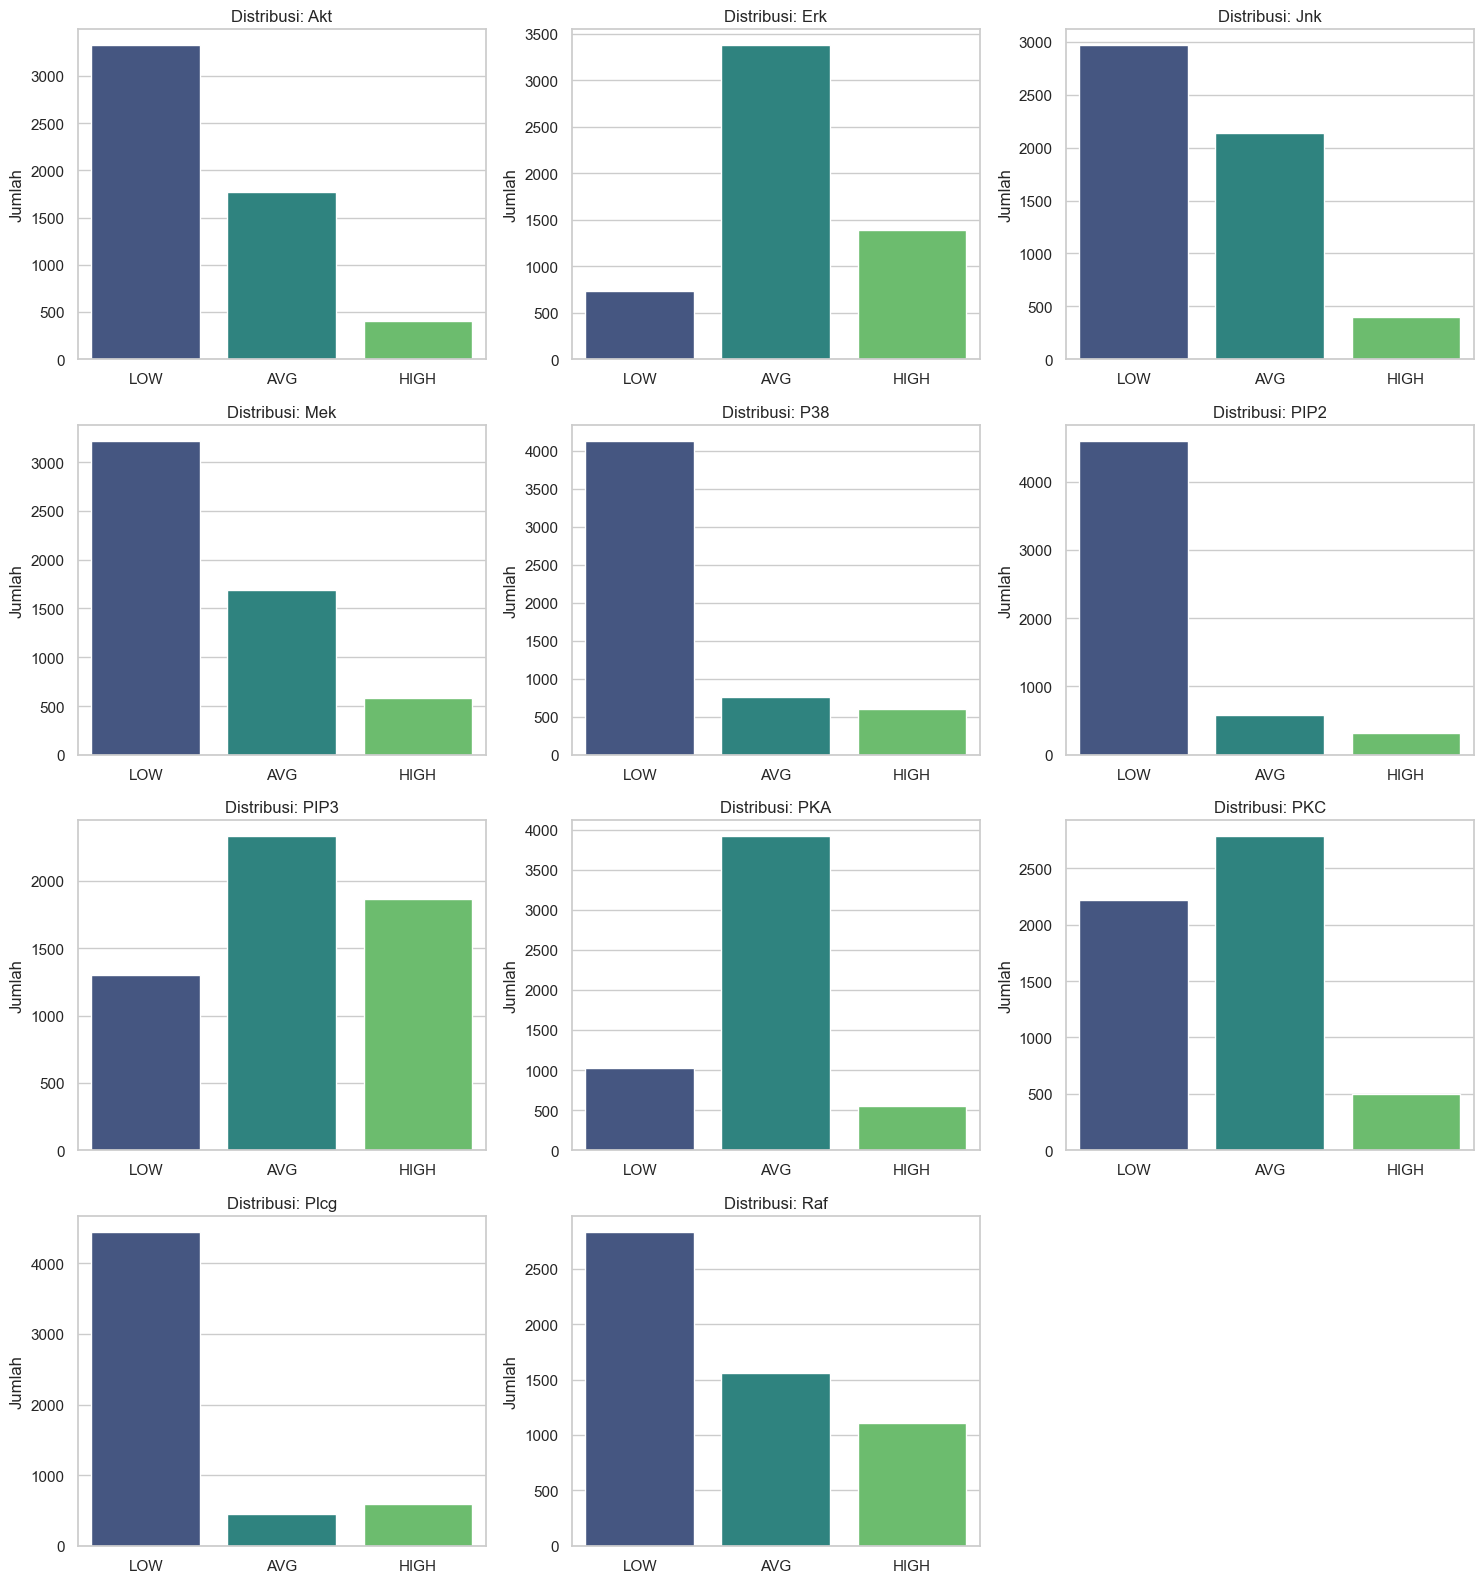

In [256]:
n_cols_plot = 3
n_rows_plot = math.ceil(len(df.columns) / n_cols_plot)
fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, 4 * n_rows_plot))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.countplot(x=col, data=df, ax=axes[i], palette='viridis', order=['LOW', 'AVG', 'HIGH'])
    axes[i].set_title(f"Distribusi: {col}")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Jumlah')
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

In [257]:
df_numeric = df.copy()
mappings = {}
ordinal_map = {'LOW': 0, 'AVG': 1, 'HIGH': 2}

In [258]:
for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        if set(df_numeric[col].unique()).issubset(set(ordinal_map.keys())):
            df_numeric[col] = df_numeric[col].map(ordinal_map)
            mappings[col] = ordinal_map
        else:
            df_numeric[col], unique = pd.factorize(df_numeric[col], sort=True)
            mappings[col] = {v: k for k, v in enumerate(unique)}

In [259]:
df_numeric.head()

,Akt,Erk,Jnk,Mek,P38,PIP2,PIP3,PKA,PKC,Plcg,Raf
0,1,1,1,2,0,0,0,0,0,0,2
1,1,1,1,0,0,0,2,1,1,0,0
2,0,1,1,0,0,0,1,1,2,0,0
3,1,2,1,2,0,0,2,0,0,0,2
4,0,1,0,0,0,0,1,2,0,0,1


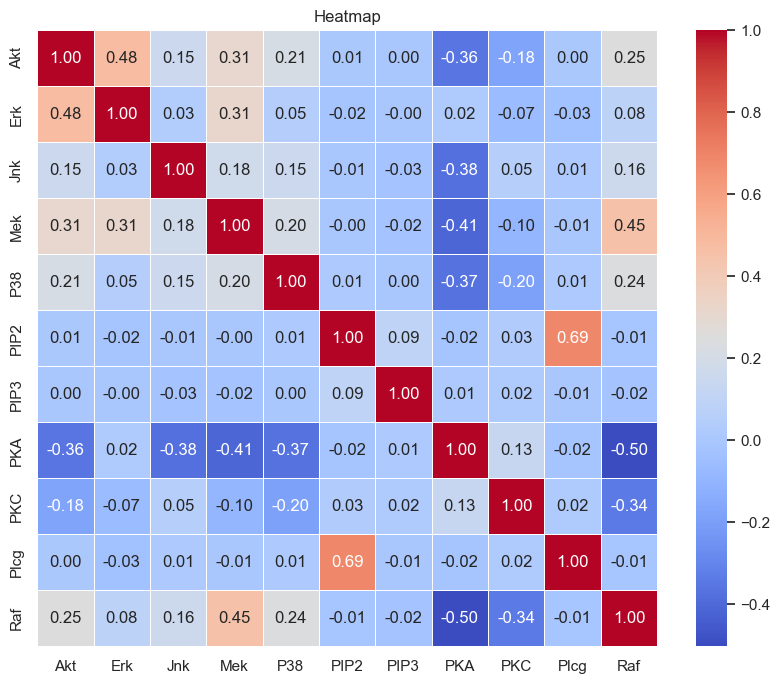

In [260]:
plt.figure(figsize=(10, 8))
corr_matrix = df_numeric.corr(method='spearman')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap")
plt.show()

Pilih PKA, Akt atau Raf sebagai target

### Membagi data train dan test

In [261]:
X_train_raw, X_test_raw = train_test_split(df, test_size=0.2, random_state=42)
X_train_num, X_test_num = train_test_split(df_numeric, test_size=0.2, random_state=42)

In [262]:
X_train_raw.shape[0]

4400

In [263]:
X_test_raw.shape[0]

1100

### Membangun Struktur Bayesian Network

In [264]:
learner = StructureLearner(threshold=0.1) 
structure, edges = learner.fit(X_train_num)

threshold korelasi > 0.1...
22 hubungan (arcs).


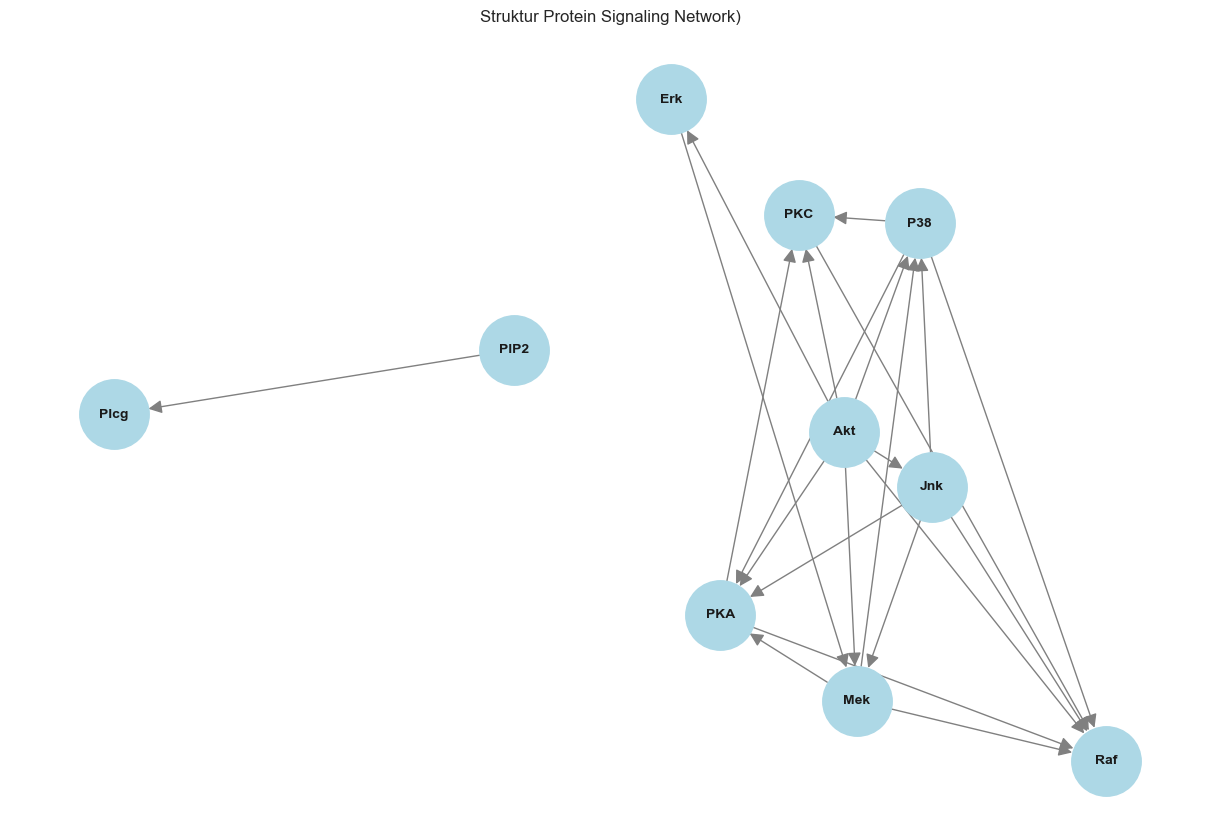

In [265]:
plt.figure(figsize=(12, 8))
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=0.6, iterations=50) 
nx.draw(G, pos, with_labels=True, 
        node_size=2500, node_color='lightblue', 
        font_size=10, font_weight='bold', 
        arrowsize=20, edge_color='gray')
plt.title(f"Struktur Protein Signaling Network)")
plt.show()

### Membangun Model Bayesian Network Learning dari Parameter Struktur Bayesian Network

In [266]:
# Latih Model menggunakan Data Asli (String) agar CPT mudah dibaca
model = BayesianNetworkLearning(structure)
model.train(X_train_raw)

### Evaluasi Model

In [267]:
target_variable = 'PKA' # bisa ganti dengan 'Erk', 'PKA', dll.
parents_of_target = structure.get(target_variable, [])

In [268]:
target_variable

'PKA'

In [269]:
parents_of_target

['Akt', 'Jnk', 'Mek', 'P38']

In [270]:
y_true = []
y_pred = []
fallback_prediction = X_train_raw[target_variable].mode()[0]

In [271]:
for idx, row in X_test_raw.iterrows():
    # Ground Truth
    actual = row[target_variable]
    # Kumpulkan evidence (nilai dari parent)
    evidence = {p: row[p] for p in parents_of_target}
    # Ambil probabilitas dari model
    probs = model.predict_proba(target_variable, evidence)
    if probs:
        # Pilih kelas dengan probabilitas tertinggi (Maximum Likelihood)
        prediction = max(probs, key=probs.get)
    else:
        # Jika kombinasi parent tidak ada di training, pakai fallback
        prediction = fallback_prediction
    y_true.append(actual)
    y_pred.append(prediction)

In [272]:
accuracy = accuracy_score(y_true, y_pred)
print(f"'{target_variable}': {accuracy:.4f}")
print(classification_report(y_true, y_pred))

'PKA': 0.8745
              precision    recall  f1-score   support

         AVG       0.86      1.00      0.92       794
        HIGH       0.72      0.18      0.29       101
         LOW       0.98      0.75      0.85       205

    accuracy                           0.87      1100
   macro avg       0.85      0.64      0.69      1100
weighted avg       0.87      0.87      0.85      1100



In [273]:
threshold = 0.60
if accuracy >= threshold:
    print(f"Akurasi {accuracy*100}% > {threshold*100}%). Diterima")

Akurasi 87.45454545454545% > 60.0%). Diterima


### Pengujian

In [274]:
inference = VariableElimination(model, X_train_raw)

In [275]:
print("P(Akt | Erk=LOW)")
result1 = inference.query(
    variables=['Akt'], 
    evidence={'Erk': 'LOW'}
)

P(Akt | Erk=LOW)
+--------------------+---------------+
| Akt                | phi(Akt)      |
+--------------------+---------------+
| AVG                | 0.3836        |
| LOW                | 0.6164        |
+--------------------+---------------+


In [276]:
print("P(PKA | PKC=HIGH)")
result2 = inference.query(
    variables=['PKA'], 
    evidence={'PKC': 'HIGH'}
)

P(PKA | PKC=HIGH)
+--------------------+---------------+
| PKA                | phi(PKA)      |
+--------------------+---------------+
| AVG                | 0.9527        |
| HIGH               | 0.0323        |
| LOW                | 0.0149        |
+--------------------+---------------+


In [277]:
print("P(Raf | Mek=AVG, Plcg=LOW)")
result3 = inference.query(
    variables=['Raf'], 
    evidence={'Mek': 'AVG', 'Plcg': 'LOW'}
)

P(Raf | Mek=AVG, Plcg=LOW)
+--------------------+---------------+
| Raf                | phi(Raf)      |
+--------------------+---------------+
| AVG                | 0.5537        |
| HIGH               | 0.0839        |
| LOW                | 0.3625        |
+--------------------+---------------+

+--------------------+---------------+
| Raf                | phi(Raf)      |
+--------------------+---------------+
| AVG                | 0.5537        |
| HIGH               | 0.0839        |
| LOW                | 0.3625        |
+--------------------+---------------+


In [278]:
print("P(Erk | PKA=AVG, Raf=HIGH)")
result3 = inference.query(
    variables=['Erk'], 
    evidence={'PKA': 'AVG', 'Raf': 'HIGH', 'Akt': 'LOW'}
)

P(Erk | PKA=AVG, Raf=HIGH)
+--------------------+---------------+
| Erk                | phi(Erk)      |
+--------------------+---------------+
| AVG                | 0.9141        |
| HIGH               | 0.0152        |
| LOW                | 0.0707        |
+--------------------+---------------+


In [279]:
print("P(Raf | PKA=LOW, PKC=LOW)")
result3 = inference.query(
    variables=['Raf'], 
    evidence={'PKA': 'LOW', 'PKC': 'LOW'}
)

P(Raf | PKA=LOW, PKC=LOW)
+--------------------+---------------+
| Raf                | phi(Raf)      |
+--------------------+---------------+
| AVG                | 0.1489        |
| HIGH               | 0.7895        |
| LOW                | 0.0617        |
+--------------------+---------------+


In [284]:
print("P(Raf | PKA=HIGH)")
result3 = inference.query(
    variables=['Raf'], 
    evidence={'PKA': 'HIGH'}
)

P(Raf | PKA=HIGH)
+--------------------+---------------+
| Raf                | phi(Raf)      |
+--------------------+---------------+
| AVG                | 0.1460        |
| HIGH               | 0.0376        |
| LOW                | 0.8164        |
+--------------------+---------------+
